# TASK #2: IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [54]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Navigate to dataset
%cd /content/drive/My Drive/Colab Notebooks/Healthcare AI Datasets/Brain_MRI


/content/drive/My Drive/Colab Notebooks/Healthcare AI Datasets/Brain_MRI


In [4]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('data_mask.csv')

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [6]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [7]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [8]:
cv2.imread(brain_df.mask_path[623]).min()

0

In [9]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [10]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [11]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [12]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [13]:
# create a image generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [14]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [15]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [16]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [19]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)



In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)



In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [21]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [22]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [24]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 10, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Epoch 1/10
177/177 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7056
Epoch 1: val_loss improved from inf to 0.66119, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 1544s 9s/step - loss: 0.6689 - accuracy: 0.7056 - val_loss: 0.6612 - val_accuracy: 0.6431
Epoch 2/10
177/177 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.8041
Epoch 2: val_loss did not improve from 0.66119
177/177 [==============================] - 25s 139ms/step - loss: 0.4180 - accuracy: 0.8041 - val_loss: 8.6895 - val_accuracy: 0.3569
Epoch 3/10
177/177 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8505
Epoch 3: val_loss improved from 0.66119 to 0.65655, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 28s 160ms/step - loss: 0.3562 - accuracy: 0.8505 - val_loss: 0.6566 - val_accuracy: 0.6391
Epoch 4/10
177/177 [==============================] - ETA: 0s - loss: 

In [25]:
p# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

In [26]:


history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

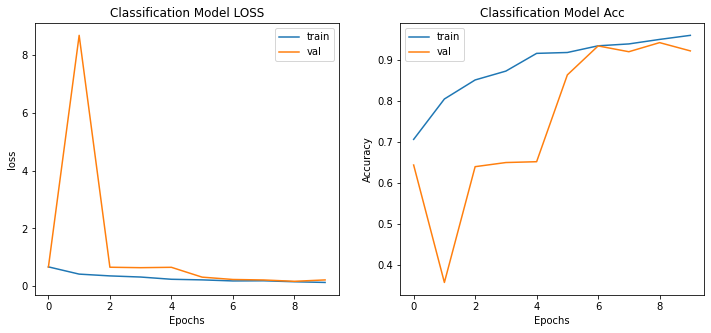

In [27]:


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);



0.8983050847457628
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       379
           1       0.88      0.83      0.85       211

    accuracy                           0.90       590
   macro avg       0.89      0.88      0.89       590
weighted avg       0.90      0.90      0.90       590



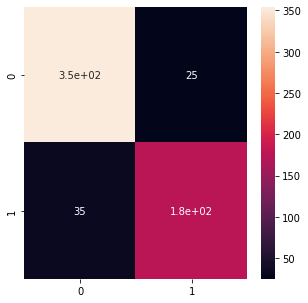

In [28]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

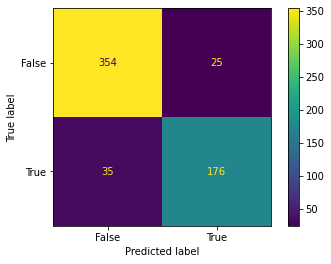

In [29]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(original, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# TASK #7: ASSESS TRAINED MODEL PERFORMANCE

In [44]:
# Load pretrained model (instead of training the model for 1+ hours) 
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [45]:
# Obtain the predicted class from the model prediction
predict = []

for i in prediction:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [46]:
predict

array(['1', '1', '1', '0', '1', '1', '0', '1', '0', '0', '1', '0', '0',
       '1', '0', '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '1',
       '1', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1',
       '1', '0', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '1', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '1', '1', '1', '0', '1', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '1', '0', '1', '1', '1', '0', '1', '1', '0',
       '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '0',
       '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '1',
       '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '1', '0', '0',
       '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '0', '0

In [47]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

590

In [48]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8983050847457628

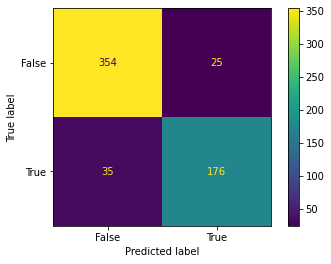

In [49]:
confusion_matrix = metrics.confusion_matrix(original, predict)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
report = classification_report(original, predict, labels = [0,1])
print(report)


              precision    recall  f1-score   support

           0       0.91      0.93      0.92       379
           1       0.88      0.83      0.85       211

   micro avg       0.90      0.90      0.90       590
   macro avg       0.89      0.88      0.89       590
weighted avg       0.90      0.90      0.90       590



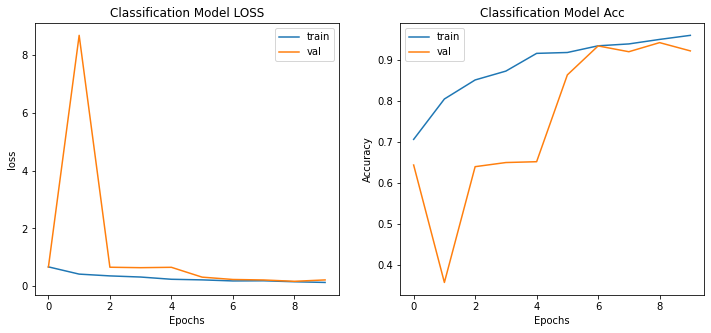

In [56]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);